In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
model = load_model("vgg19_finetuned_best_model.h5")

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_DIR = 'vggface2_subset/val'

val_gen = ImageDataGenerator(rescale=1./255)

val_data = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # important to keep order for evaluation
)


Found 9000 images belonging to 300 classes.


In [4]:
loss, accuracy = model.evaluate(val_data)
print(f"\n✅ Validation Accuracy: {accuracy * 100:.2f}%")
print(f"🧮 Validation Loss: {loss:.4f}")

282/282 [==============================] - 63s 184ms/step - loss: 0.2131 - accuracy: 0.9451

✅ Validation Accuracy: 94.51%
🧮 Validation Loss: 0.2131


In [5]:
import numpy as np

# Predict all validation images
pred_probs = model.predict(val_data)
pred_classes = np.argmax(pred_probs, axis=1)

# True labels
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Optional: Print first 10 predictions vs actuals
for i in range(10):
    print(f"Predicted: {class_labels[pred_classes[i]]}, Actual: {class_labels[true_classes[i]]}")


Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001
Predicted: n000001, Actual: n000001


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [7]:
# Get predicted class indices
pred_probs = model.predict(val_data, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)

# True class indices
true_classes = val_data.classes

# Class labels (folder names)
class_labels = list(val_data.class_indices.keys())


282/282 [==============================] - 48s 170ms/step


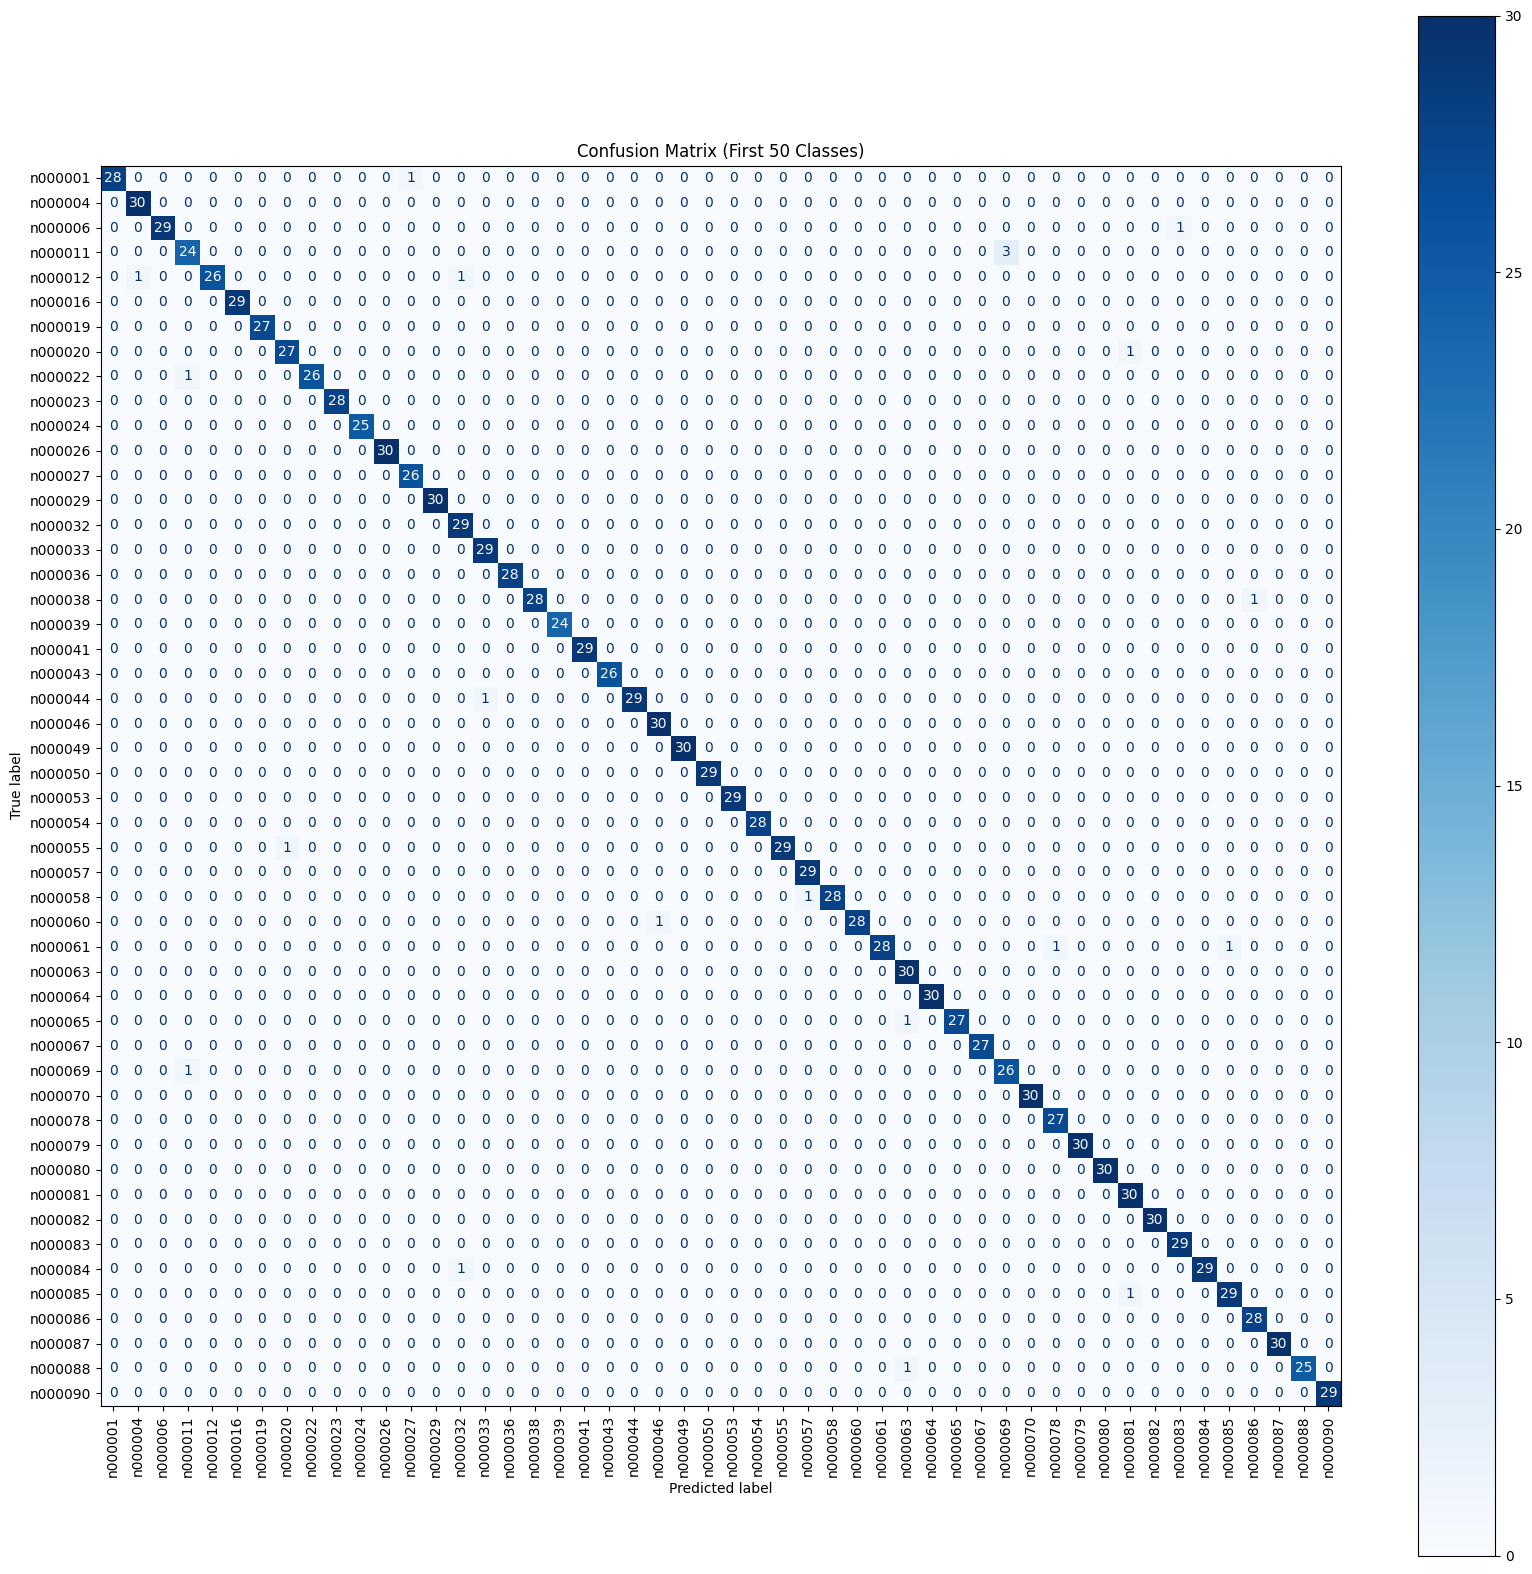

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define range
selected_classes = list(range(50))  # or range(100), etc.
label_map = {cls: i for i, cls in enumerate(selected_classes)}
labels_subset = [class_labels[i] for i in selected_classes]

# Filter only where both true and pred classes are in selected range
mask = np.isin(true_classes, selected_classes) & np.isin(pred_classes, selected_classes)
y_true_filtered = true_classes[mask]
y_pred_filtered = pred_classes[mask]

# Remap labels
y_true_mapped = np.array([label_map[i] for i in y_true_filtered])
y_pred_mapped = np.array([label_map[i] for i in y_pred_filtered])

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_mapped, y_pred_mapped)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_subset)
fig, ax = plt.subplots(figsize=(20, 20))  # Make bigger if you're plotting >50
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix (First 50 Classes)")
plt.show()


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Step 1: Compute the full confusion matrix
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Step 2: Remove diagonal (correct predictions)
conf_matrix_no_diag = conf_matrix.copy()
np.fill_diagonal(conf_matrix_no_diag, 0)

# Step 3: Flatten and get top N confused pairs
top_n = 10  # You can increase this number
flat_indices = np.argpartition(conf_matrix_no_diag.flatten(), -top_n)[-top_n:]
sorted_indices = flat_indices[np.argsort(-conf_matrix_no_diag.flatten()[flat_indices])]

# Step 4: Show most confused class pairs
print(f"\n🔍 Top {top_n} Most Confused Class Pairs:\n")
for idx in sorted_indices:
    i, j = divmod(idx, conf_matrix.shape[1])
    print(f"❌ {class_labels[i]} ↔ {class_labels[j]} → Confused {conf_matrix[i, j]} times")



🔍 Top 10 Most Confused Class Pairs:

❌ n000345 ↔ n000094 → Confused 5 times
❌ n000295 ↔ n000309 → Confused 3 times
❌ n000116 ↔ n000117 → Confused 3 times
❌ n000011 ↔ n000069 → Confused 3 times
❌ n000363 ↔ n000854 → Confused 3 times
❌ n000024 ↔ n000395 → Confused 3 times
❌ n000285 ↔ n000447 → Confused 3 times
❌ n000463 ↔ n000355 → Confused 2 times
❌ n000355 ↔ n000444 → Confused 2 times
❌ n000039 ↔ n000140 → Confused 2 times


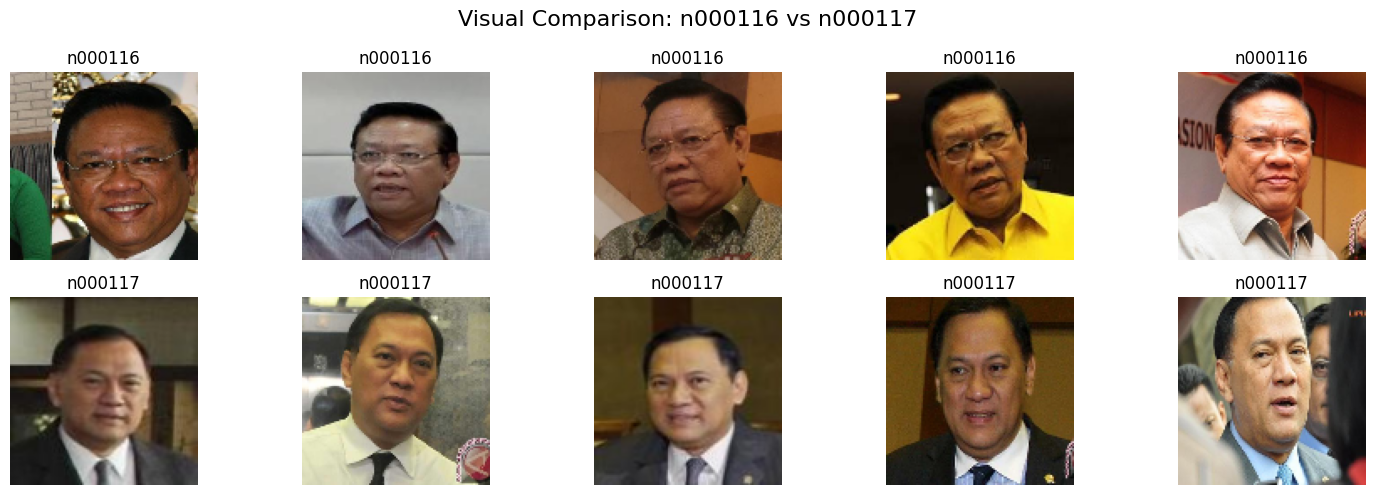

In [10]:
import os
import matplotlib.pyplot as plt
import cv2

# Classes to visualize — use the ones from your top confused list
class_a = "n000116"  # Replace with one of the confused labels
class_b = "n000117"  # Replace with the other

val_dir = "vggface2_subset/val"

# Number of images to show per class
num_images = 5

def load_images(class_name, num_images=5):
    class_path = os.path.join(val_dir, class_name)
    image_files = sorted(os.listdir(class_path))[:num_images]
    images = []
    for fname in image_files:
        path = os.path.join(class_path, fname)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = cv2.resize(img, (112, 112))  # Resize for display
        images.append(img)
    return images

# Load images
images_a = load_images(class_a, num_images)
images_b = load_images(class_b, num_images)

# Plot side by side
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
for i in range(num_images):
    axes[0, i].imshow(images_a[i])
    axes[0, i].set_title(f"{class_a}")
    axes[0, i].axis('off')

    axes[1, i].imshow(images_b[i])
    axes[1, i].set_title(f"{class_b}")
    axes[1, i].axis('off')

plt.suptitle(f"Visual Comparison: {class_a} vs {class_b}", fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, pred_classes, target_names=class_labels, output_dict=True)

# Display summary stats (macro avg, weighted avg)
print("\n📊 Classification Report Summary:\n")
for k in ['macro avg', 'weighted avg']:
    print(f"{k.title()}:")
    for metric, value in report[k].items():
        print(f"  {metric}: {value:.4f}")
    print()

# Optionally view specific class:
sample_class = class_labels[0]  # change index to see others
print(f"\n🎯 Example Class ({sample_class}) Metrics:")
for metric, value in report[sample_class].items():
    print(f"  {metric}: {value:.4f}")



📊 Classification Report Summary:

Macro Avg:
  precision: 0.9482
  recall: 0.9451
  f1-score: 0.9453
  support: 9000.0000

Weighted Avg:
  precision: 0.9482
  recall: 0.9451
  f1-score: 0.9453
  support: 9000.0000


🎯 Example Class (n000001) Metrics:
  precision: 1.0000
  recall: 0.9333
  f1-score: 0.9655
  support: 30.0000


In [12]:
from sklearn.metrics import classification_report
import pandas as pd

# Create classification report
report = classification_report(true_classes, pred_classes, target_names=class_labels, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter out "accuracy", "macro avg", etc.
class_metrics = report_df.iloc[:-3]  # Keep only actual class rows


C:\4_2_Project\faceid\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  if sys.path[0] == "":
C:\4_2_Project\faceid\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


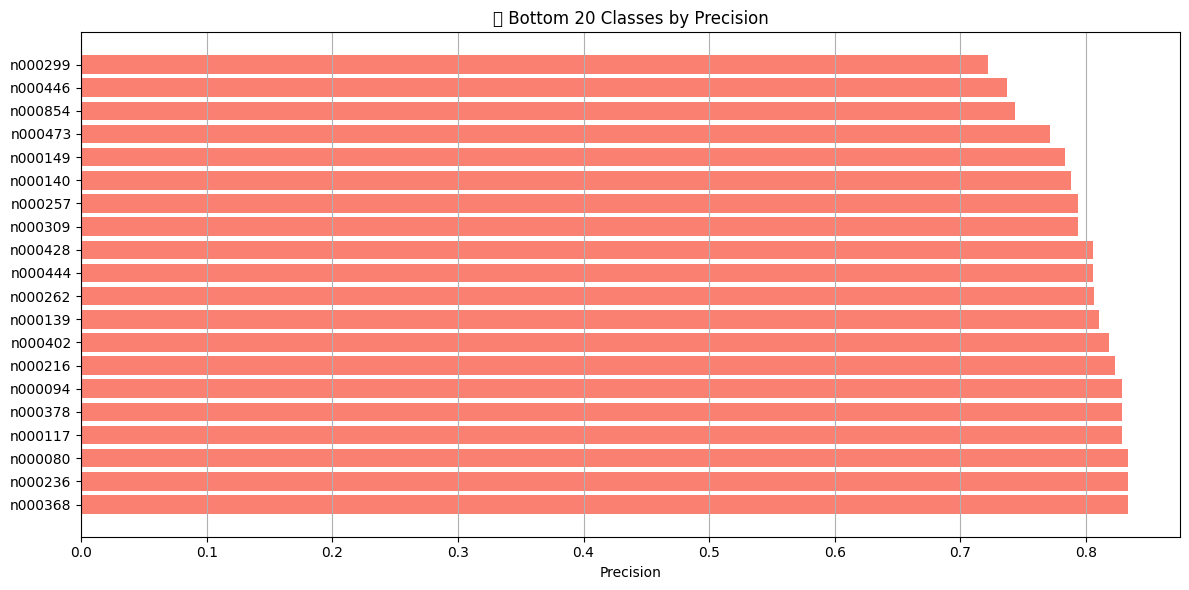

In [13]:
import matplotlib.pyplot as plt

# Sort by precision
lowest_precision = class_metrics.sort_values("precision").head(20)

plt.figure(figsize=(12, 6))
plt.barh(lowest_precision.index, lowest_precision["precision"], color="salmon")
plt.title("🔻 Bottom 20 Classes by Precision")
plt.xlabel("Precision")
plt.grid(True, axis='x')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()


C:\4_2_Project\faceid\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  # Remove the CWD from sys.path while we load stuff.
C:\4_2_Project\faceid\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


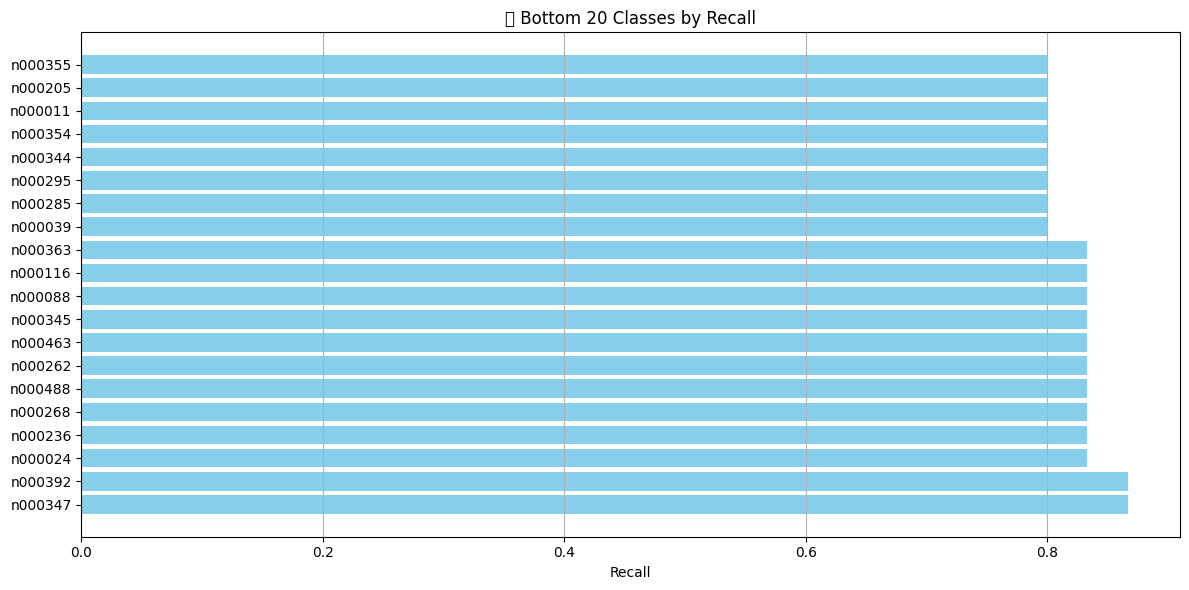

In [14]:
# Sort by recall
lowest_recall = class_metrics.sort_values("recall").head(20)

plt.figure(figsize=(12, 6))
plt.barh(lowest_recall.index, lowest_recall["recall"], color="skyblue")
plt.title("🔻 Bottom 20 Classes by Recall")
plt.xlabel("Recall")
plt.grid(True, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
